In [1]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid, linear_mpc, ref, zero, pidf
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter

ACC_G = 9.81

sns.set_theme()


/home/risak/controls_challenge/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_rollout(sim, end=1000):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(sim.target_lataccel_history[:end], label="Target Lateral Acceleration", alpha=0.5)
  ax.plot(sim.current_lataccel_history[:end], label="Actual Lateral Acceleration", alpha=0.5)
  ax.plot(gaussian_filter(sim.current_lataccel_history[:end], sigma=5), label="Smoothed Actual Lateral Acceleration", alpha=0.5)
  ax.plot(sim.action_history[:end], label="Action", alpha=0.5)
  # ax.plot([x[0] for x in sim.state_history], label="roll", alpha=0.5)

  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Lateral Acceleration")
  ax.set_title("Rollout")
  # ax.set_ylim(-0.5, 0.5)
  plt.show()

In [3]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
controller = pidf.Controller()
sim = TinyPhysicsSimulator(model, "./data/08975.csv", controller=controller, debug=False)
sim.rollout()

{'lataccel_cost': 2.773649683487447,
 'jerk_cost': 18.99584172834226,
 'total_cost': 157.67832590271462}

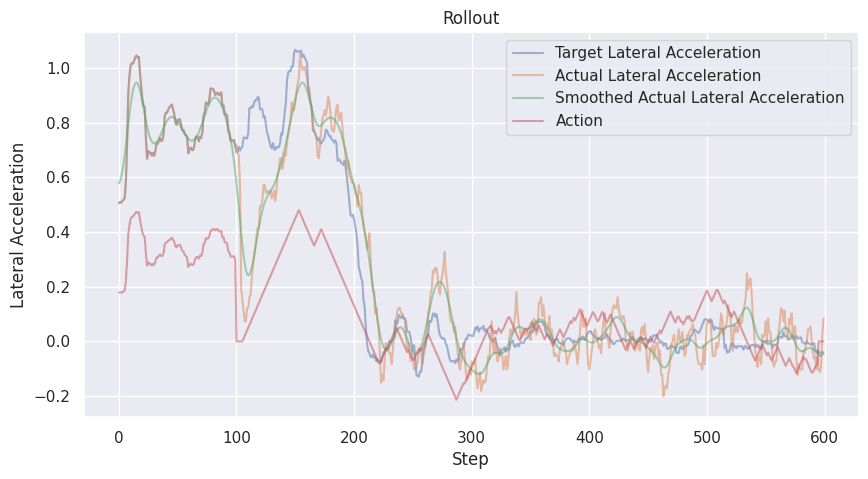

In [5]:
plot_rollout(sim)

### Controller stats

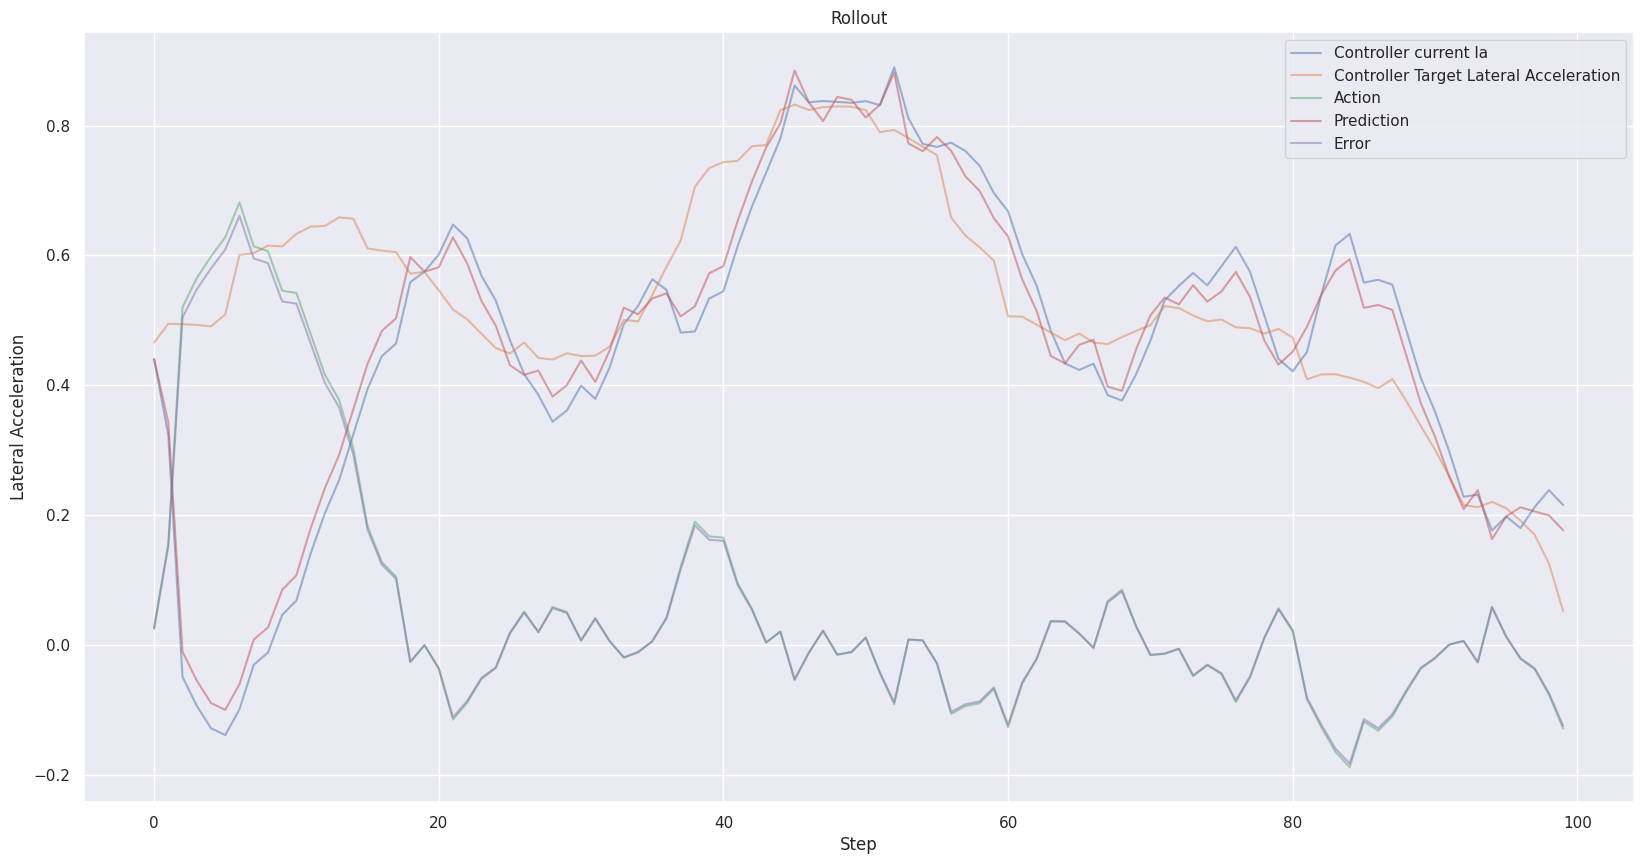

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
# ax.plot(sim.target_lataccel_history[102:200], label="Target Lateral Acceleration", alpha=0.5)
# ax.plot(sim.current_lataccel_history[102: 200], label="Current Lateral Acceleration", alpha=0.5)
ax.plot(controller.la_history[2:102], label="Controller current la", alpha=0.5)
ax.plot(controller.target_la_history[:100], label="Controller Target Lateral Acceleration", alpha=0.5)
ax.plot(controller.delta_action_history[:100], label="Action", alpha=0.5)
ax.plot(controller.predict_la_history[:100], label="Prediction", alpha=0.5)
ax.plot(controller.error_history[:100], label="Error", alpha=0.5)

# ax.plot([x[0] for x in sim.state_history], label="roll", alpha=0.5)

ax.legend()
ax.set_xlabel("Step")
ax.set_ylabel("Lateral Acceleration")
ax.set_title("Rollout")
plt.show()

lag: 5


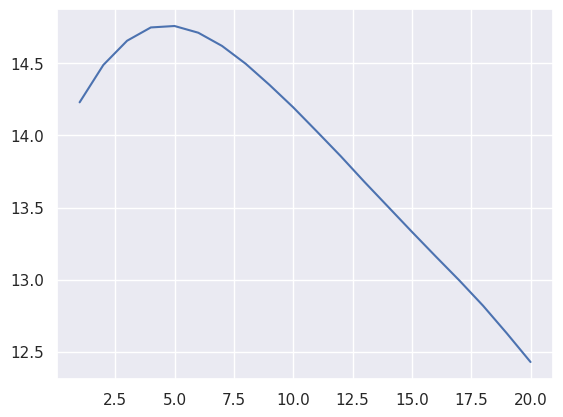

lag: 5
alpha: 1.3944699160054341
beta: -0.014832987632515768
R^2: 0.7688077039310179


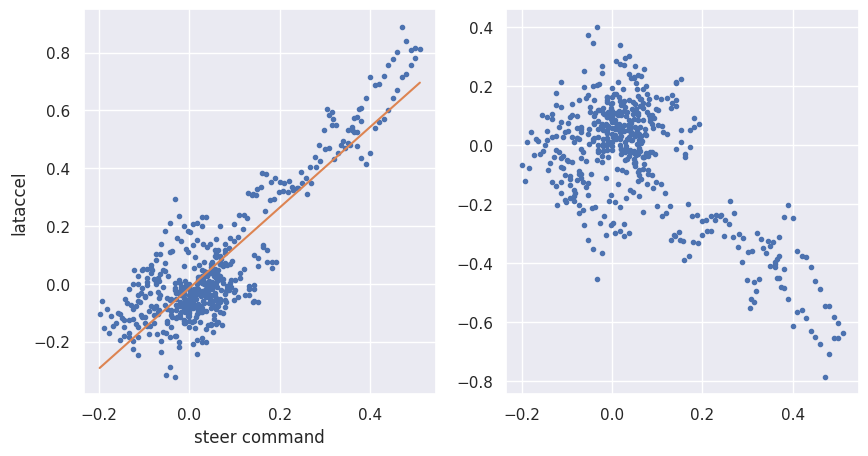

In [5]:
def linear_lsq(x, y, lag):
    length = len(x)
    alpha = np.sum((y[lag:] - y[lag:].mean()) * (x[:length-lag] - x[:length-lag].mean())) / (np.sum((x[:length-lag] - x[:length-lag].mean()) ** 2) + 1e-8)
    beta = y[lag:].mean() - alpha * x[:length-lag].mean()

    ssr = np.sum((alpha * x[:length-lag] + beta - y[lag:])**2)
    sst = np.sum((y[lag:] - y[lag:].mean())**2) + 1e-8
    r2 = 1 - ssr / sst

    return alpha, beta, r2

roll_lataccel_history = [x[0] for x in sim.state_history][100:]
steer_la = np.array(sim.current_lataccel_history)[100:] - np.array(roll_lataccel_history)
steerCommands = np.array(sim.action_history)[100:]
vEgo = np.array([x[1] for x in sim.state_history[100:]])
aEgo = np.array([x[2] for x in sim.state_history[100:]])

roll_lataccel_history_preset = [x[0] for x in sim.state_history][:100]
steer_la_preset = np.array(sim.current_lataccel_history)[:100] - np.array(roll_lataccel_history_preset)
steerCommands_preset = np.array(sim.action_history)[:100]


length = len(steerCommands)


corr = signal.correlate(steer_la - steer_la.mean(), steerCommands - steerCommands.mean())[length: length + 20]
lags = signal.correlation_lags(length, length)[length: length + 20]
lag = lags[np.argmax(corr)]
print(f'lag: {lag}')
lag = max(0, lag)

plt.plot(lags, corr)
plt.show()

# test_fit = np.array([linear_lsq(steerCommands, steer_la, x)[2] for x in range(lag, lag + 10)])
# lag += np.argmax(test_fit)

print(f'lag: {lag}')

# lag=2
alpha = np.sum((steer_la[lag:] - steer_la[lag:].mean()) * (steerCommands[:length-lag] - steerCommands[:length-lag].mean())) / np.sum((steerCommands[:length-lag] - steerCommands[:length-lag].mean()) ** 2)
beta = steer_la[lag:].mean() - alpha * steerCommands[:length-lag].mean()
ssr = np.sum((alpha * steerCommands[:length-lag] + beta - steer_la[lag:])**2)
sst = np.sum((steer_la[lag:] - steer_la[lag:].mean())**2)
r2 = 1 - ssr / sst
print(f'alpha: {alpha}\nbeta: {beta}\nR^2: {r2}')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(steerCommands[:length-lag], steer_la[lag:], '.')
x = np.linspace(steerCommands.min(), steerCommands.max(), 2)
ax[0].plot(x, alpha * x + beta)
ax[0].set_xlabel('steer command')
ax[0].set_ylabel('lataccel')

ax[1].plot(steerCommands[:length-lag], steerCommands[:length-lag] - steer_la[lag:] * alpha + beta, '.')

# plt.xlim(-2, 2)
# plt.ylim(-3, 3)
plt.show()



# fig, ax = plt.subplots(2, 1, figsize=(7, 10))
# ax[0].scatter(action_history[:-lag], steer_lataccel_history[lag:], marker='.', linewidths=0.5)
# ax[1].scatter(action_history[:100], steer_lataccel_history[lag:100+lag], marker='.', linewidths=0.5)



# plt.xlabel('steer command')
# plt.ylabel('actual lataccel')
# # plt.xlim(-2, 2)
# # plt.ylim(-3, 3)
# plt.show()

### Lag Correlation analysis

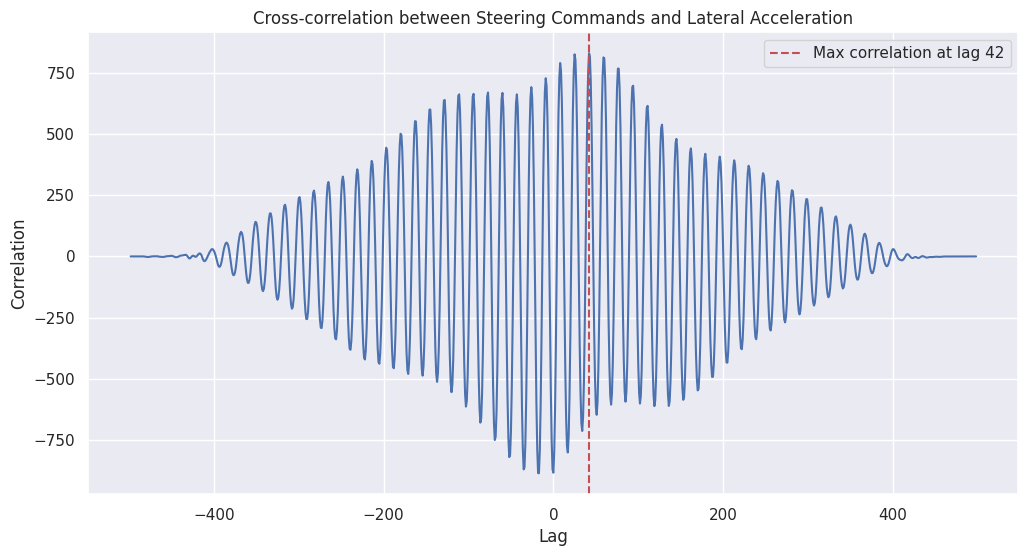

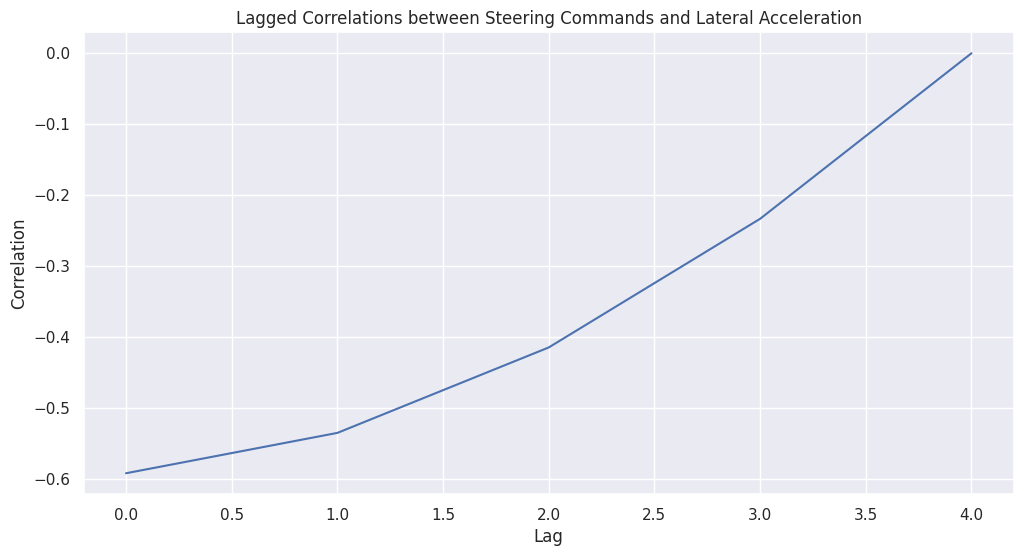

Maximum correlation occurs at lag: 42


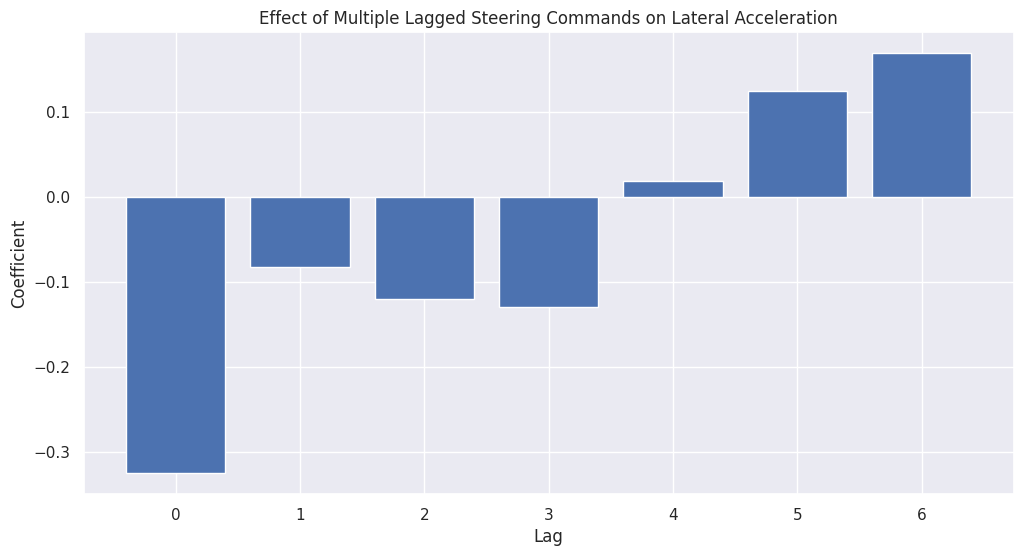

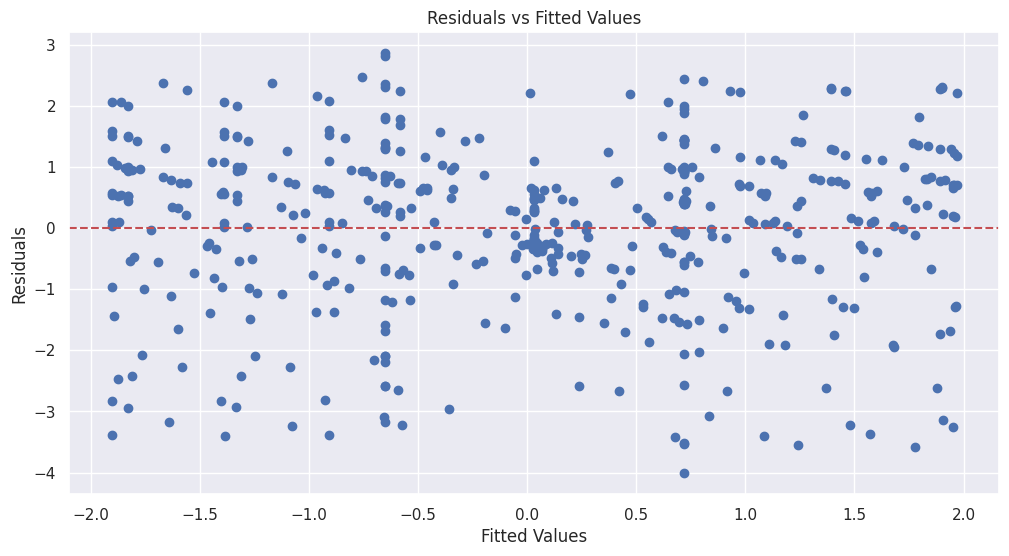

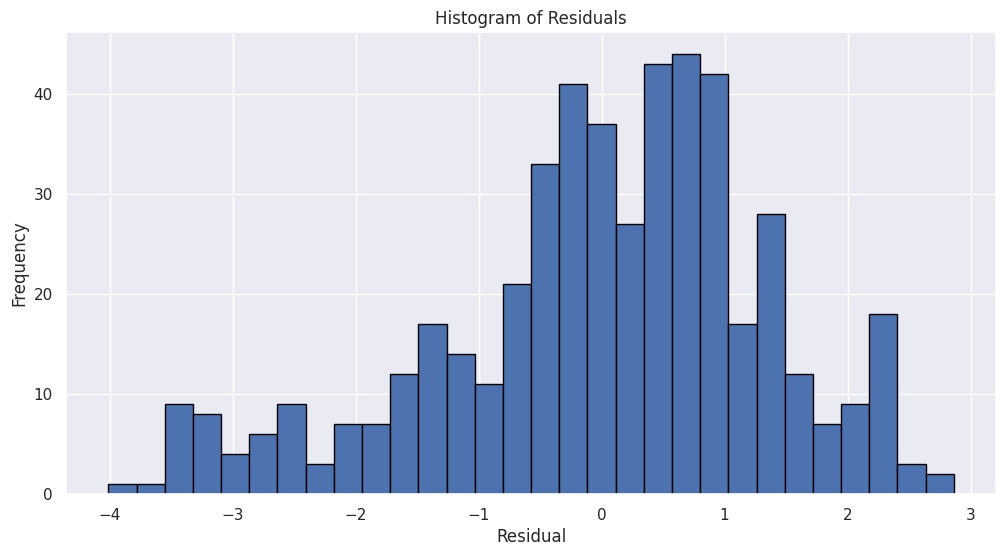

Normality test p-value: 3.1536476213356355e-07
The residuals do not appear to be normally distributed (p < 0.05)
Coefficients for multiple lagged inputs:
Lag 0: -0.3247259838115123
Lag 1: -0.08245530746697431
Lag 2: -0.12000945827978145
Lag 3: -0.12870433034231288
Lag 4: 0.019387266453379126
Lag 5: 0.12445927898010159
Lag 6: 0.16925794985552728

Residual analysis:
Mean of residuals: 1.7295157868400004e-16
Standard deviation of residuals: 1.3497641463705283


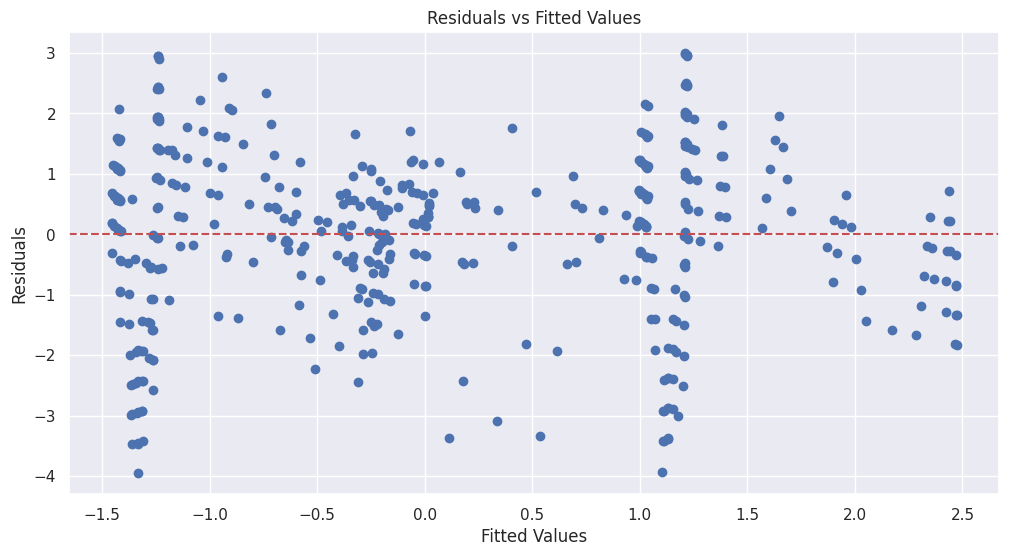

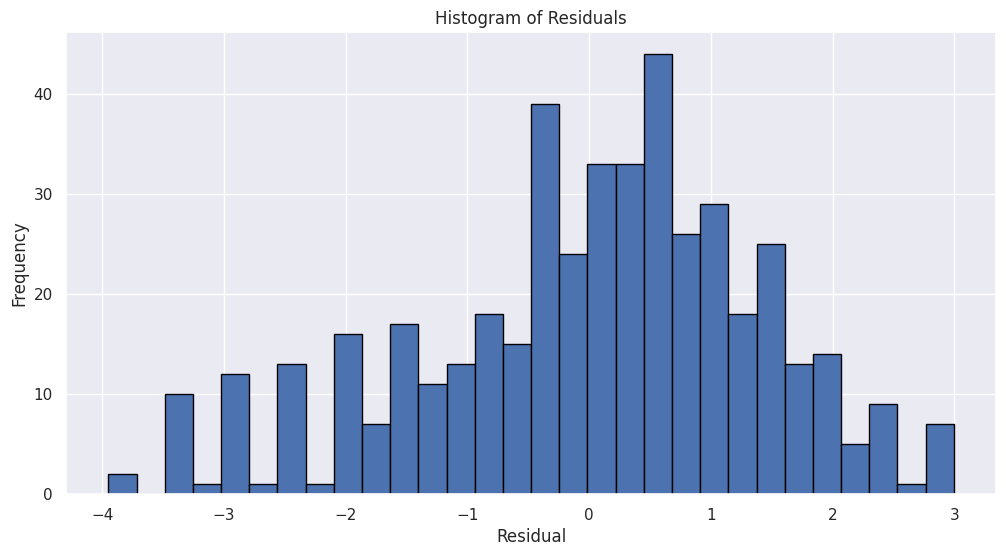

Normality test p-value: 0.00026909400181834354
The residuals do not appear to be normally distributed (p < 0.05)
Coefficients for speed and lagged inputs:
 3.469756910226994
 0.6139828506480333
 -0.10661854475772563

Residual analysis:
Mean of residuals: 1.0805846856745507e-15
Standard deviation of residuals: 1.4108877410009568

Analyzing relationship at different speeds:


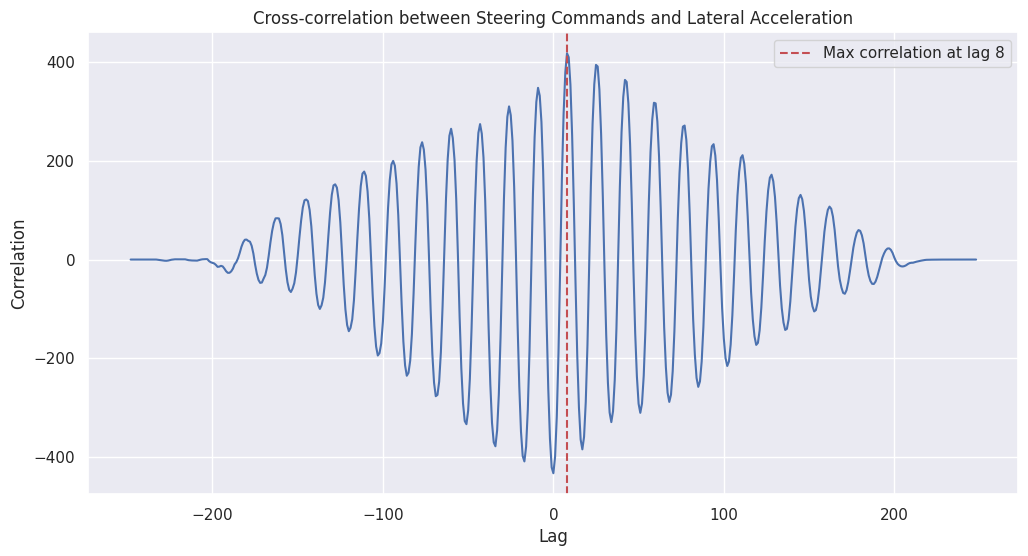

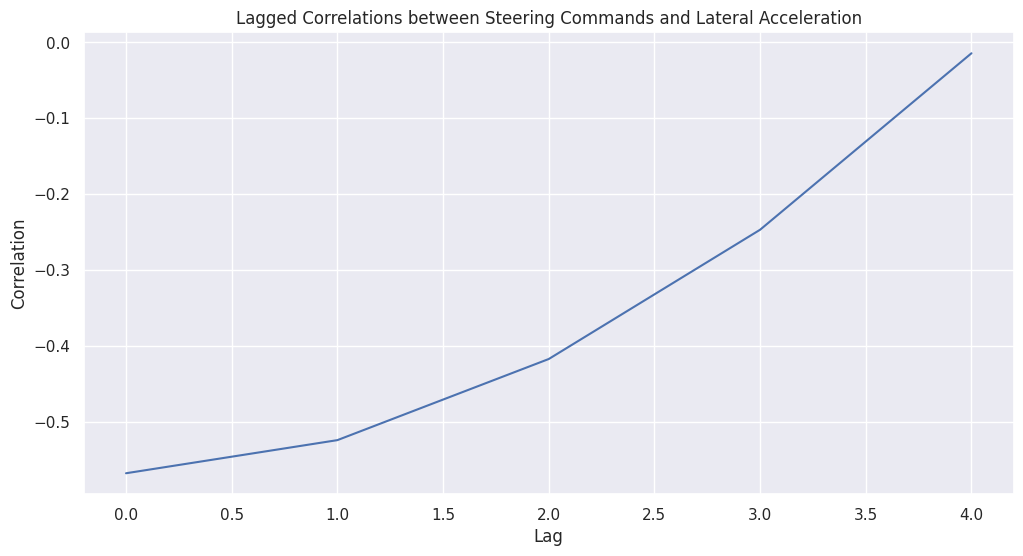

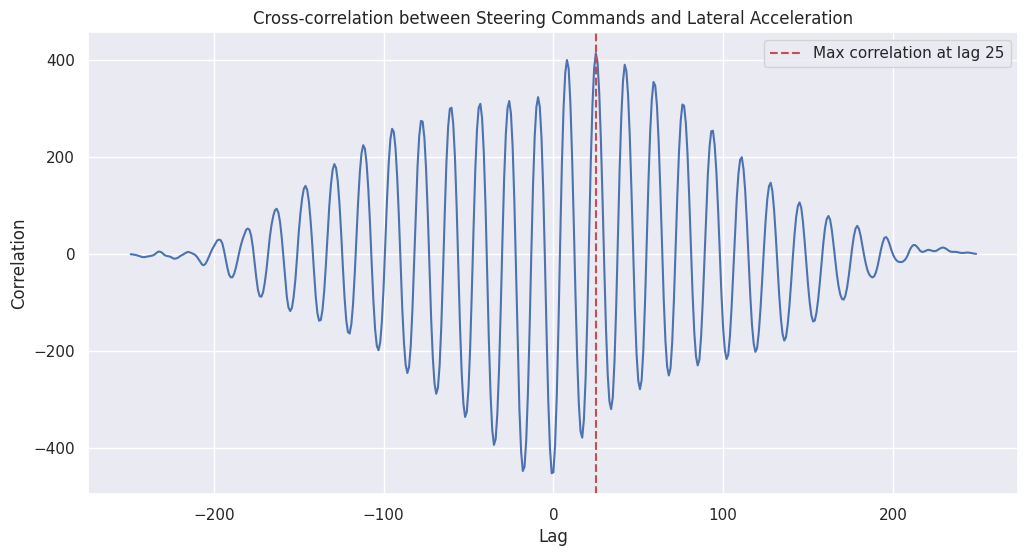

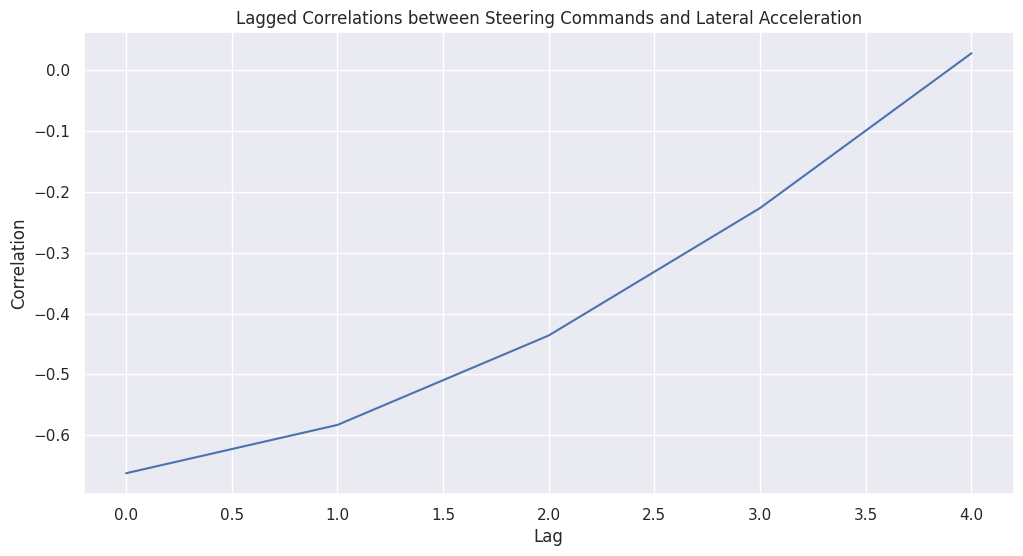

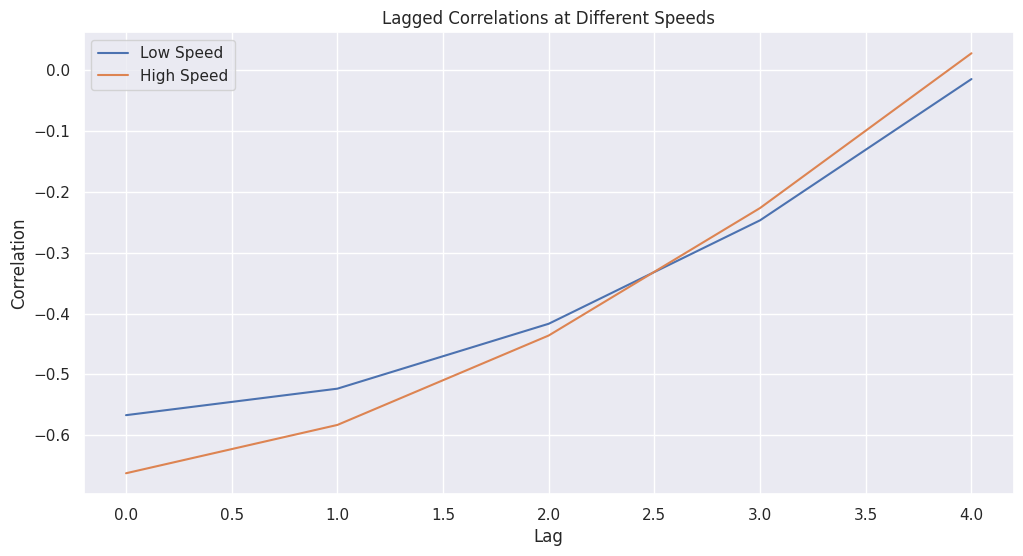

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import pearsonr, normaltest

# Assuming the data is already loaded as provided in the initial code snippet
roll_lataccel_history = [x[0] for x in sim.state_history][100:]
steer_la = np.array(sim.current_lataccel_history)[100:] - np.array(roll_lataccel_history)
steerCommands = np.array(sim.action_history)[100:]
vEgo = np.array([x[1] for x in sim.state_history[100:]])
aEgo = np.array([x[2] for x in sim.state_history[100:]])

def analyze_steering_lataccel_relationship(steerCommands, steer_la, max_lag=5):
    # Compute cross-correlation
    cross_corr = signal.correlate(steer_la, steerCommands, mode='full')
    lags = signal.correlation_lags(len(steer_la), len(steerCommands), mode='full')
    
    # Find the lag with maximum correlation
    max_corr_lag = lags[np.argmax(cross_corr)]
    
    # Plot cross-correlation
    plt.figure(figsize=(12, 6))
    plt.plot(lags, cross_corr)
    plt.title('Cross-correlation between Steering Commands and Lateral Acceleration')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.axvline(x=max_corr_lag, color='r', linestyle='--', label=f'Max correlation at lag {max_corr_lag}')
    plt.legend()
    plt.show()
    
    # Compute lagged correlations
    lagged_correlations = []
    for lag in range(max_lag):
        correlation, _ = pearsonr(steerCommands[:steerCommands.shape[0]-lag], steer_la[lag:])
        lagged_correlations.append(correlation)
    
    # Plot lagged correlations
    plt.figure(figsize=(12, 6))
    plt.plot(range(max_lag), lagged_correlations)
    plt.title('Lagged Correlations between Steering Commands and Lateral Acceleration')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()
    
    return max_corr_lag, lagged_correlations

def analyze_speed_lag(steerCommands, vEgo, steer_la, lag):
    lagged_inputs = np.column_stack([steerCommands[:steerCommands.shape[0] - lag], vEgo[lag:]])
    X = np.hstack((np.ones((lagged_inputs.shape[0], 1)), lagged_inputs))
    coefficients = np.linalg.lstsq(X, steer_la[lag:], rcond=None)[0]

    # Calculate predicted values and residuals
    y_pred = X @ coefficients
    residuals = steer_la[lag:] - y_pred

    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    
    # Histogram of residuals
    plt.figure(figsize=(12, 6))
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()
    
    # Perform normality test
    _, p_value = normaltest(residuals)
    print(f"Normality test p-value: {p_value}")
    if p_value < 0.05:
        print("The residuals do not appear to be normally distributed (p < 0.05)")
    else:
        print("The residuals appear to be normally distributed (p >= 0.05)")
    
    return coefficients, residuals

def analyze_multiple_input_effect(steerCommands, steer_la, window_size=5):
    # Create lagged versions of steerCommands
    lagged_inputs = np.column_stack([np.roll(steerCommands, i) for i in range(window_size)])
    lagged_inputs = lagged_inputs[window_size-1:]
    steer_la_trimmed = steer_la[window_size-1:]
    
    # Perform multiple linear regression
    X = np.hstack((np.ones((lagged_inputs.shape[0], 1)), lagged_inputs))
    coefficients = np.linalg.lstsq(X, steer_la_trimmed, rcond=None)[0]
    
     # Calculate predicted values and residuals
    y_pred = X @ coefficients
    residuals = steer_la_trimmed - y_pred
    
    # Plot coefficients
    plt.figure(figsize=(12, 6))
    plt.bar(range(window_size), coefficients[1:])
    plt.title('Effect of Multiple Lagged Steering Commands on Lateral Acceleration')
    plt.xlabel('Lag')
    plt.ylabel('Coefficient')
    plt.show()
    
    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    
    # Histogram of residuals
    plt.figure(figsize=(12, 6))
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()
    
    # Perform normality test
    _, p_value = normaltest(residuals)
    print(f"Normality test p-value: {p_value}")
    if p_value < 0.05:
        print("The residuals do not appear to be normally distributed (p < 0.05)")
    else:
        print("The residuals appear to be normally distributed (p >= 0.05)")
    
    return coefficients, residuals

# Analyze the relationship
max_lag, lagged_correlations = analyze_steering_lataccel_relationship(steerCommands, steer_la)
print(f"Maximum correlation occurs at lag: {max_lag}")

# Analyze multiple input effect
coefficients, residuals = analyze_multiple_input_effect(steerCommands, steer_la, 7)
print("Coefficients for multiple lagged inputs:")
for i, coef in enumerate(coefficients[1:]):
    print(f"Lag {i}: {coef}")

# Additional analysis for residuals
print("\nResidual analysis:")
print(f"Mean of residuals: {np.mean(residuals)}")
print(f"Standard deviation of residuals: {np.std(residuals)}")

# Analyze speed and lagged input 
coefficients, residuals = analyze_speed_lag(steerCommands, vEgo, steer_la, max_lag)
print("Coefficients for speed and lagged inputs:")
for i, coef in enumerate(coefficients
):
    print(f" {coef}")

# Additional analysis for residuals
print("\nResidual analysis:")
print(f"Mean of residuals: {np.mean(residuals)}")
print(f"Standard deviation of residuals: {np.std(residuals)}")

# Additional analysis: Check if the relationship changes with velocity
low_speed_mask = vEgo < np.median(vEgo)
high_speed_mask = vEgo >= np.median(vEgo)

print("\nAnalyzing relationship at different speeds:")
_, low_speed_correlations = analyze_steering_lataccel_relationship(steerCommands[low_speed_mask], steer_la[low_speed_mask])
_, high_speed_correlations = analyze_steering_lataccel_relationship(steerCommands[high_speed_mask], steer_la[high_speed_mask])

plt.figure(figsize=(12, 6))
plt.plot(range(len(low_speed_correlations)), low_speed_correlations, label='Low Speed')
plt.plot(range(len(high_speed_correlations)), high_speed_correlations, label='High Speed')
plt.title('Lagged Correlations at Different Speeds')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()
plt.show()

### Speed correlation analysis

Fit: 0.969713844592532x + -0.0012270494827752525
Preset Fit: 0.7049x + 0.0013


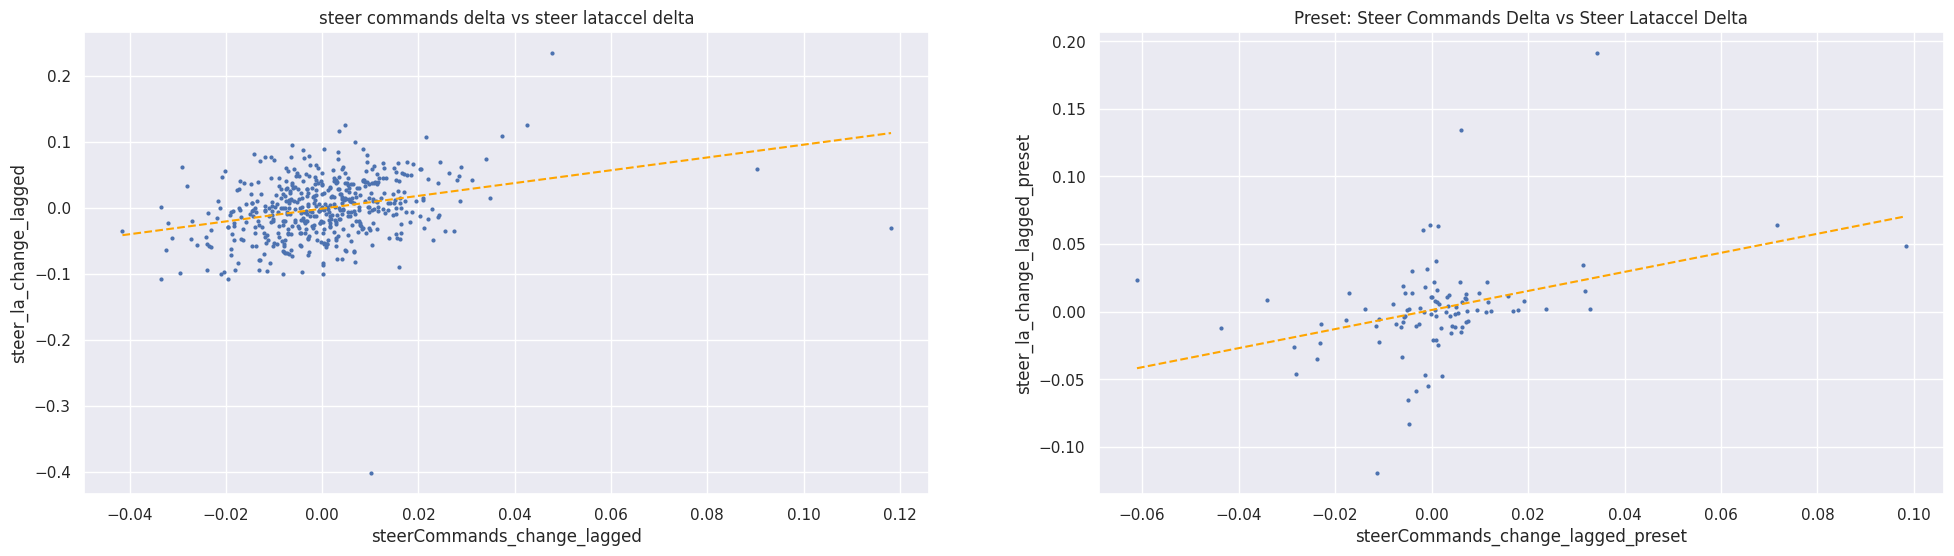

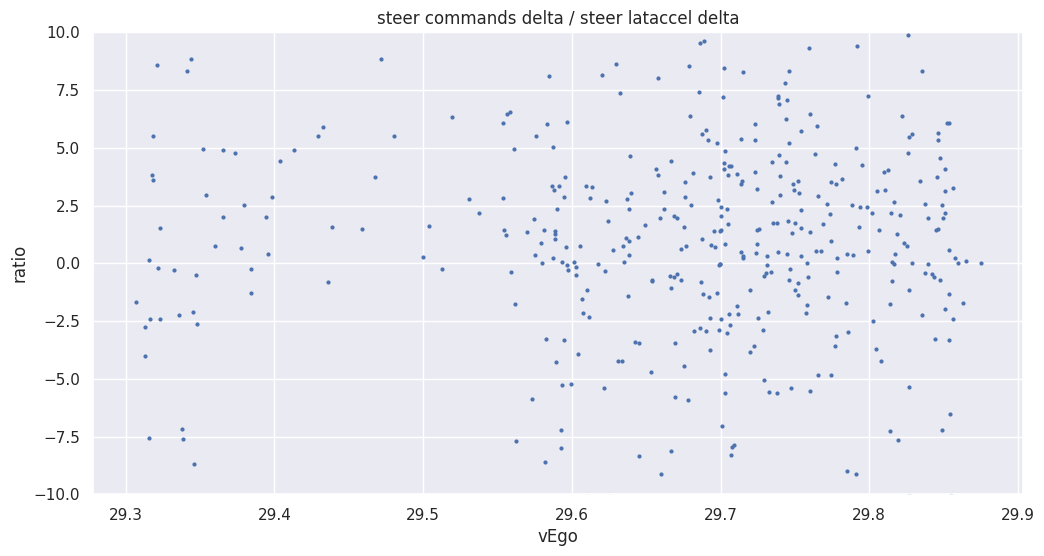

R^2: 0.0841670243595306, Adjusted R^2: 0.08045919854722106


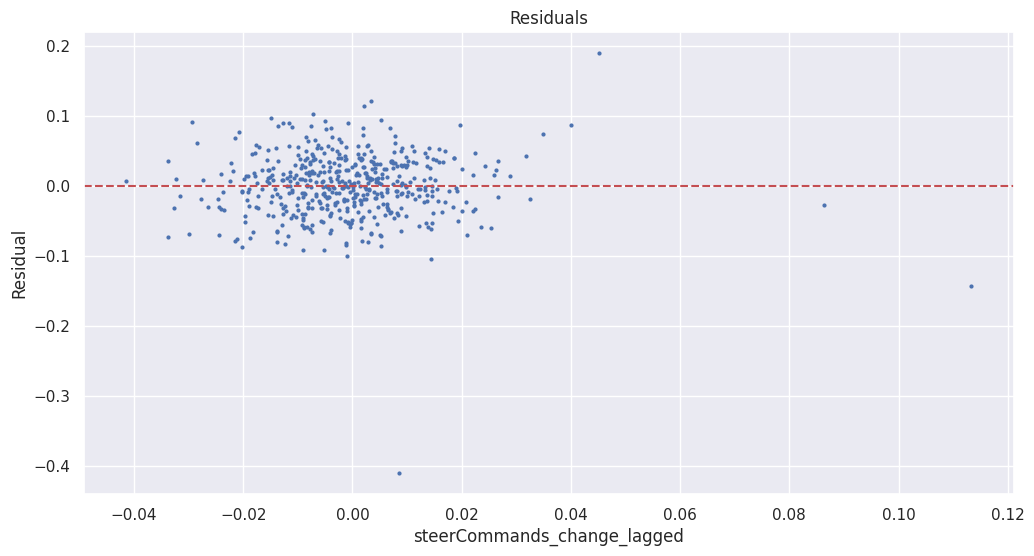

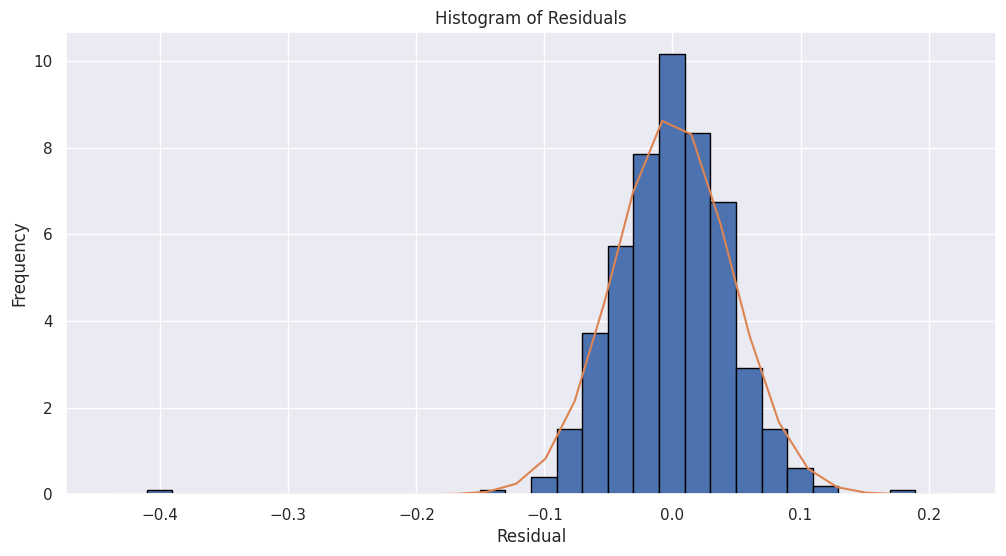

In [21]:
from scipy.stats import norm 

# Visualize the relationship
max_lag = 2
steer_la_change = np.diff(steer_la)
steer_la_change_lagged = steer_la_change[max_lag:]
steer_la_lagged = steer_la[max_lag: ]
steerCommands_change = np.diff(steerCommands)
steerCommands_change_lagged = steerCommands_change[:steerCommands_change.shape[0] - max_lag]
steerCommands_lagged = steerCommands[:steerCommands.shape[0] - max_lag]
vEgo_lagged = vEgo[max_lag+1:]
ratio = steer_la_change_lagged / steerCommands_change_lagged

steer_la_change_preset = np.diff(steer_la_preset)
steer_la_change_lagged_preset = steer_la_change_preset[max_lag:]
steer_la_lagged_preset = steer_la_preset[max_lag: ]
steerCommands_change_preset = np.diff(steerCommands_preset)
steerCommands_change_lagged_preset = steerCommands_change_preset[:steerCommands_change_preset.shape[0] - max_lag]
steerCommands_lagged_preset = steerCommands[:steerCommands_preset.shape[0] - max_lag]

X = np.column_stack([np.ones_like(steerCommands_change_lagged), steerCommands_change_lagged])
coefficients = np.linalg.lstsq(X, steer_la_change_lagged, rcond=None)[0]
y_pred = X @ coefficients
residuals = steer_la_change_lagged - y_pred

X_preset = np.column_stack([np.ones_like(steerCommands_change_lagged_preset), steerCommands_change_lagged_preset])
coefficients_preset = np.linalg.lstsq(X_preset, steer_la_change_lagged_preset, rcond=None)[0]
y_pred_preset = X_preset @ coefficients_preset

fig, ax = plt.subplots(1, 2, figsize=(24, 6))
ax[0].scatter((steerCommands_change_lagged), steer_la_change_lagged, s=4)
ax[0].plot([steerCommands_change_lagged.min(), steerCommands_change_lagged.max()],
           [y_pred[steerCommands_change_lagged.argmin()],y_pred[steerCommands_change_lagged.argmax()]],
           '--', c='orange')
ax[0].set_title('steer commands delta vs steer lataccel delta')
ax[0].set_xlabel('steerCommands_change_lagged')
ax[0].set_ylabel('steer_la_change_lagged')

ax[1].scatter(steerCommands_change_lagged_preset, steer_la_change_lagged_preset, s=4)
ax[1].plot([steerCommands_change_lagged_preset.min(), steerCommands_change_lagged_preset.max()],
           [y_pred_preset[steerCommands_change_lagged_preset.argmin()], y_pred_preset[steerCommands_change_lagged_preset.argmax()]],
           '--', c='orange')
ax[1].set_title('Preset: Steer Commands Delta vs Steer Lataccel Delta')
ax[1].set_xlabel('steerCommands_change_lagged_preset')
ax[1].set_ylabel('steer_la_change_lagged_preset')

print(f'Fit: {coefficients[1]}x + {coefficients[0]}')
print(f'Preset Fit: {coefficients_preset[1]:.4f}x + {coefficients_preset[0]:.4f}')


plt.figure(figsize=(12, 6))
plt.scatter(vEgo_lagged, (steer_la_change_lagged / steerCommands_change_lagged), s=4)
plt.ylim(-10, 10)
plt.title('steer commands delta / steer lataccel delta')
plt.xlabel('vEgo')
plt.ylabel('ratio')
plt.show()

# Adjusted R^2
ss_residual = np.sum((steer_la_change_lagged - y_pred) ** 2)
ss_total = np.sum((steer_la_change_lagged - steer_la_change_lagged.mean()) ** 2)
r_squared = 1 - (ss_residual / ss_total)
adjusted_r_squared = 1 - (1 - r_squared) * (y_pred.shape[0] - 1) / (y_pred.shape[0] - 2 - 1)
print(f'R^2: {r_squared}, Adjusted R^2: {adjusted_r_squared}')

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, s=4)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('steerCommands_change_lagged')
plt.ylabel('Residual')

# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='black', density=True)
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 30)
plt.plot(x_axis, norm.pdf(x_axis, residuals.mean(), residuals.std()))
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# # Perform normality test
# _, p_value = normaltest(residuals)
# print(f"Normality test p-value: {p_value}")
# if p_value < 0.05:
#     print("The residuals do not appear to be normally distributed (p < 0.05)")
# else:
#     print("The residuals appear to be normally distributed (p >= 0.05)")